---
title : "Fragility Curve uit een cache"
execute:
    output: asis
---

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt

path = Path.cwd() / "data_sets" / "6.fragility_curve_from_cache"

Voor het vervangen van een fragility curve door een eerder berekende fragility curve maken we gebruik van een `cache`.<br>
Hierbij vervangen we de huidige fragility curve met een voorberekende fragility curve die past bij de geselecteerde maatregel. <br>
Als de curve er niet is die pas bij de maatregel, verschuiven we de originele curve. Hiervoor is ook een koppelings nodig tussen maatregel en effect.<br>
De standaard manier is om voor alle dijkvakken en faalmechanismes in een keer alles aan te passen. <br>

1. Voor alle dijkvakken en faalmechanismes in een keer alle fragility curves aanpassen met `LoadCachedFragilityCurveMultiple`. 

Daarnaast zijn er nog 3 opties om fragility curves aan te passen als je het niet op de standaard manier wilt doen.
Deze opties zijn afhankelijk van je toepassing. 

1. Voor een dijkvak, maar voor alle faalmechanismen in een keer de fragility curves aanpassen met `LoadCachedFragilityCurve`.

1. Per dijk vak de fragility curve aanpassen voor een mechanisme met `LoadCachedFragilityCurveOneFailureMechanism`. 

1. Handmatig logica implementeren om de bijbehorende fragility curve aan te passen met de `FragilityCurve` class. 




### LoadCachedFragilityCurveMultiple

Bij de Multiple werkt het net zo: als je alleen één maatregel getal geeft wordt dat voor alle faalmechanismes en dijkvakken gebruikt.
Voor verschillende maatregels per faalmechanisme en dijkvak kan een mapping bestand worden meegegeven.

```yaml
GlobalVariables:
    rootdir: "data_sets/6.fragility_curve_from_cache"
    moments: [-24,0,24,48]
    LoadCachedFragilityCurve:
        default_measure_id: 0

DataAdapter:
    default_options:
        csv:
            sep: ","
    fragility_curve_multi_section_multi_failure:
        type: csv
        file: "fragility_curve_multi_section_multi_failure.csv"
    measures_to_effect:
        type: csv
        file: "measures_to_effect.csv"
    section_id_to_measure_id:
        type: csv
        file: "section_id_to_measure_id.csv"
    resulting_fragility_curve:
        type: csv
        file: "hidden_resulting_fragility_one_section_multi_failure.csv"
```

In [2]:
from toolbox_continu_inzicht.base.data_adapter import Config, DataAdapter

config = Config(
    config_path=path
    / "test_fragility_curve_from_cache_multi_section_multi_failure.yaml"
)
config.lees_config()
data_adapter = DataAdapter(config=config)

In [3]:
from toolbox_continu_inzicht.fragility_curves import LoadCachedFragilityCurveMultiple

load_cached_fragility_curve = LoadCachedFragilityCurveMultiple(
    data_adapter=data_adapter
)
load_cached_fragility_curve.run(
    input=[
        "fragility_curve_multi_section_multi_failure",
        "measures_to_effect",
        "section_id_to_measure_id",
    ],
    output="resulting_fragility_curve",
)

In de koppel tabel zien we dat alleen section 102 voor mechanisme 2 de maatregel 1 krijgt, en voor mechanisme 3 geen maatregel (0).<br>
Voor section 103 is het andersom. Als we de resultaten bekijken zien we dat dit goed gaat.

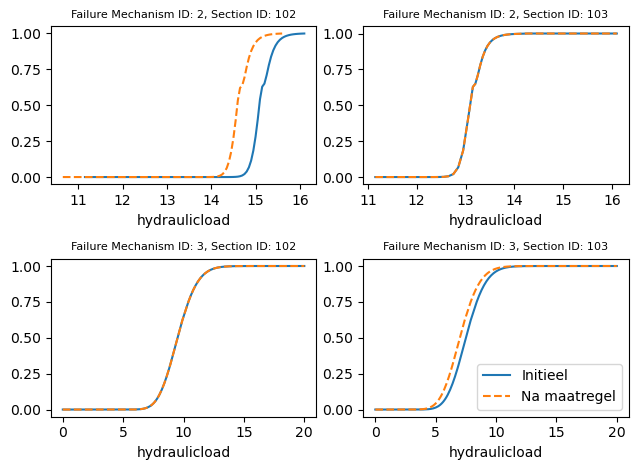

In [4]:
failure_mechanism_ids = load_cached_fragility_curve.df_in[
    "failuremechanism_id"
].unique()
df_in = load_cached_fragility_curve.df_in
df_out = load_cached_fragility_curve.df_out
fig, ax = plt.subplots(2, 2)
for i, fm_id in enumerate(failure_mechanism_ids):
    for j, section_id in enumerate(df_in["section_id"].unique()):
        df_in_section = df_in[df_in["section_id"] == section_id]
        df_out_section = df_out[df_out["section_id"] == section_id]
        df_in_section[df_in_section["failuremechanism_id"] == fm_id].set_index(
            "hydraulicload"
        )["failure_probability"].plot(ax=ax[i, j])
        df_out_section[df_out_section["failuremechanism_id"] == fm_id].set_index(
            "hydraulicload"
        )["failure_probability"].plot(ax=ax[i, j], ls="--")
        ax[i, j].set_title(
            f"Failure Mechanism ID: {fm_id}, Section ID: {section_id}", fontsize=8
        )
    plt.legend(["Initieel", "Na maatregel"])
fig.tight_layout()

In [5]:
data_adapter.input("section_id_to_measure_id")

,section_id,failuremechanism_id,measure_id
0,102,2,1
1,102,3,0
2,103,2,0
3,103,3,1


In [6]:
data_adapter.input("measures_to_effect")

,measure_id,effect
0,1,0.50
1,2,0.75
2,3,1.00
3,4,1.25


In het voorbeeld hier boven waren alle measure_ids beschikbaar, we kunnen ook een maatregel id gebruiken die niet in de cache zit. Dat wordt het bijbehorende effect uit de data adapter `measures_to_effect` gehaald om daar een verschuiving mee te realiseren<br>

```yaml
...
DataAdapter:
...
    section_id_to_measure_id_not_cached:
        type: csv
        file: "section_id_to_measure_id_not_cached.csv"
...
```

In [7]:
data_adapter.input("section_id_to_measure_id_not_cached")

,section_id,failuremechanism_id,measure_id
0,102,2,1
1,102,3,0
2,103,2,4
3,103,3,1


In [8]:
data_adapter.input("fragility_curve_multi_section_multi_failure").measure_id.unique()

array([0, 1, 2, 3])

Zo zien we dat het opgegeven measure_id 3 niet in de cache zit, dus wordt het effect van 1,25 gebruikt om de fragiluty curve rechtsbovenin te verschuiven. <br>

In [9]:
from toolbox_continu_inzicht.fragility_curves import LoadCachedFragilityCurveMultiple

load_cached_fragility_curve = LoadCachedFragilityCurveMultiple(
    data_adapter=data_adapter
)
load_cached_fragility_curve.run(
    input=[
        "fragility_curve_multi_section_multi_failure",
        "measures_to_effect",
        "section_id_to_measure_id_not_cached",
    ],
    output="resulting_fragility_curve",
)

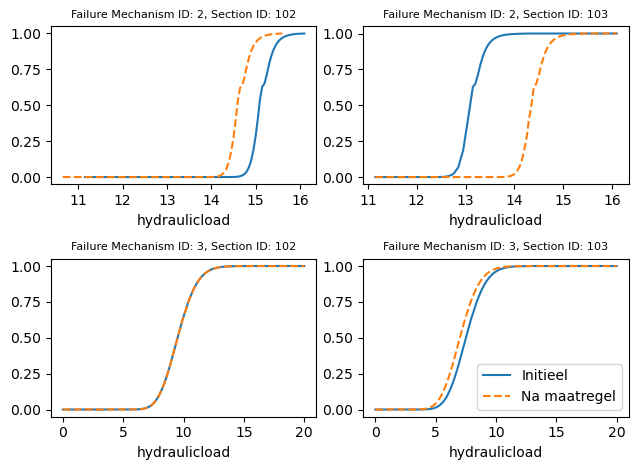

In [10]:
failure_mechanism_ids = load_cached_fragility_curve.df_in[
    "failuremechanism_id"
].unique()
df_in = load_cached_fragility_curve.df_in
df_out = load_cached_fragility_curve.df_out
fig, ax = plt.subplots(2, 2)
for i, fm_id in enumerate(failure_mechanism_ids):
    for j, section_id in enumerate(df_in["section_id"].unique()):
        df_in_section = df_in[df_in["section_id"] == section_id]
        df_out_section = df_out[df_out["section_id"] == section_id]
        df_in_section[df_in_section["failuremechanism_id"] == fm_id].set_index(
            "hydraulicload"
        )["failure_probability"].plot(ax=ax[i, j])
        df_out_section[df_out_section["failuremechanism_id"] == fm_id].set_index(
            "hydraulicload"
        )["failure_probability"].plot(ax=ax[i, j], ls="--")
        ax[i, j].set_title(
            f"Failure Mechanism ID: {fm_id}, Section ID: {section_id}", fontsize=8
        )
    plt.legend(["Initieel", "Na maatregel"])
fig.tight_layout()

## Alternatieve opties

In sommige gevallen wil je niet voor alle dijkvakken en faalmechanismes in een keer de fragility curves aanpassen, dan kan je ook de volgende functies gebruiken om in stukjes de fragility curves aan te passen.

1. Als je voor één dijkvak, maar voor alle faalmechanismen in een keer de fragility curves aanpassen met `LoadCachedFragilityCurve`.

1. Als je per dijkvak één fragility curve wilt aanpassen voor één mechanisme met `LoadCachedFragilityCurveOneFailureMechanism`. 

Mocht de je behoefte hebben aan nog meer flexibiliteit, bijvoorbeeld om automatisch de fragility curve aan te passen op basis van bepaalde criteria, kan je ook:

1. Handmatig logica implementeren om de bijbehorende fragility curve aan te passen met de `FragilityCurve` class. 


### LoadCachedFragilityCurve

De volgende configuratie wordt gebruikt voor het laden van een set fragility curves vanuit een bestanden en hier wordt een maatregel toegepast op verschillende faalmechanisme voor een specifiek dijkvak. 
Omdat de maatregel anders kan zijn per faalmechanisme, is een koppeling van faalmechanisme naar maatregel worden mee gegeven. 

```yaml
GlobalVariables:
    rootdir: "data_sets/6.fragility_curve_from_cache"
    moments: [-24,0,24,48]
    LoadCachedFragilityCurve:
        default_measure_id: 0

DataAdapter:
    default_options:
        csv:
            sep: ","
    fragility_curve_one_section_multi_failure:
        type: csv
        file: "fragility_curve_one_section_multi_failure.csv"
    measures_to_effect:
        type: csv
        file: "measures_to_effect.csv"
    failuremechanism_id_to_measure_id:
        type: csv
        file: "failuremechanism_id_to_measure_id.csv"
    resulting_fragility_curve:
        type: csv
        file: "hidden_resulting_fragility_one_section_multi_failure.csv"
```

In [11]:
config = Config(
    config_path=path / "test_fragility_curve_from_cache_one_section_multi_failure.yaml"
)
config.lees_config()
data_adapter = DataAdapter(config=config)

In [12]:
from toolbox_continu_inzicht.fragility_curves import LoadCachedFragilityCurve

load_cached_fragility_curve = LoadCachedFragilityCurve(data_adapter=data_adapter)
load_cached_fragility_curve.run(
    input=[
        "fragility_curve_one_section_multi_failure",
        "measures_to_effect",
        "failuremechanism_id_to_measure_id",
    ],
    output="resulting_fragility_curve",
)

In [13]:
data_adapter.input("failuremechanism_id_to_measure_id")

,failuremechanism_id,measure_id
0,2,1
1,3,0


Hier zien we dat de mechanisme 2 wel aan gepast wordt, maar 2 niet. Als we de resulaten bekijken zien we dat dit goed gaat.

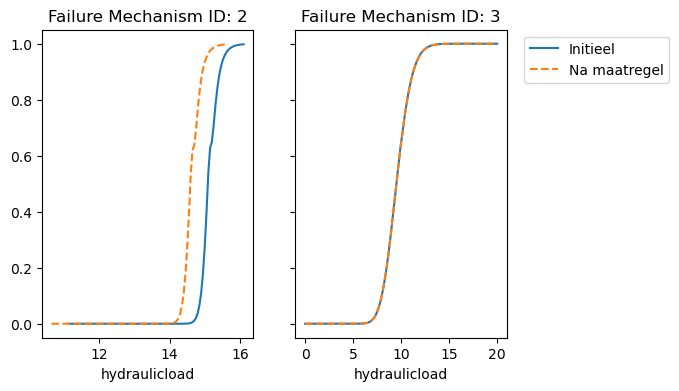

In [14]:
failure_mechanism_ids = load_cached_fragility_curve.df_in[
    "failuremechanism_id"
].unique()
df_in = load_cached_fragility_curve.df_in
df_out = load_cached_fragility_curve.df_out
fig, ax = plt.subplots(1, 2, figsize=(6, 4), sharey=True)
for i, fm_id in enumerate(failure_mechanism_ids):
    df_in[df_in["failuremechanism_id"] == fm_id].set_index("hydraulicload")[
        "failure_probability"
    ].plot(ax=ax[i])
    df_out[df_out["failuremechanism_id"] == fm_id].set_index("hydraulicload")[
        "failure_probability"
    ].plot(ax=ax[i], ls="--")
    ax[i].set_title(f"Failure Mechanism ID: {fm_id}")
    if i == 1:
        ax[i].legend(["Initieel", "Na maatregel"], bbox_to_anchor=(1.05, 1))

### LoadCachedFragilityCurveOneFailureMechanism

De volgende configuratie wordt gebruikt voor het laden van een set fragility curves vanuit een bestanden en hier wordt een maatregel toegepast op een specifiek faalmechanisme voor een specifiek dijkvak.

```yaml
GlobalVariables:
    rootdir: "data_sets/6.fragility_curve_from_cache"
    moments: [-24,0,24,48]
    LoadCachedFragilityCurve:
        default_measure_id: 0

DataAdapter:
    default_options:
        csv:
            sep: ","
    fragility_curve_one_section_one_failure:
        type: csv
        file: "fragility_curve_one_section_one_failure.csv"
    resulting_fragility_curve:
        type: csv
        file: "hidden_resulting_fragility_one_section_one_failure.csv"
```

In [15]:
config = Config(
    config_path=path / "test_fragility_curve_from_cache_one_section_one_failure.yaml"
)
config.lees_config()
data_adapter = DataAdapter(config=config)

In [16]:
from toolbox_continu_inzicht.fragility_curves import (
    LoadCachedFragilityCurveOneFailureMechanism,
)

load_cached_fragility_curve = LoadCachedFragilityCurveOneFailureMechanism(
    data_adapter=data_adapter
)
load_cached_fragility_curve.run(
    input=["fragility_curve_one_section_one_failure", "measures_to_effect"],
    output="resulting_fragility_curve",
    measure_id=1,
)

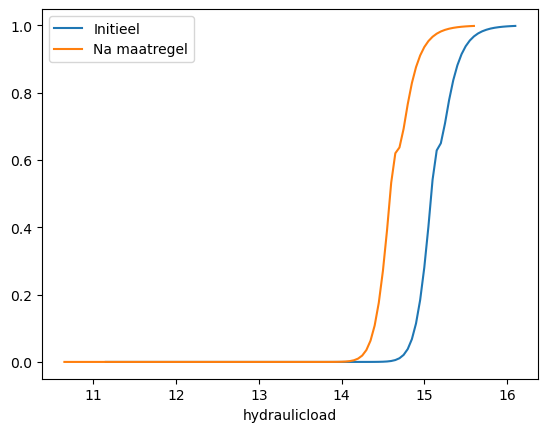

In [17]:
load_cached_fragility_curve.df_in.set_index("hydraulicload")[
    "failure_probability"
].plot()
load_cached_fragility_curve.df_out.set_index("hydraulicload")[
    "failure_probability"
].plot()
plt.legend(["Initieel", "Na maatregel"]);

### FragilityCurve
 
We geven hier een voobeeld hoe je met de `FragilityCurve` class zelf een curve uit de cache kunt laden. <br>
Dit is wat ingewikkelder, maar geeft wel de meeste vrijheid, omdat je zelf de logica kunt bepalen om de juiste curve te selecteren.
In dit voorbeeld wordt alleen voor één vak en één faalmechanisme de maatregel aangepast.
Je kan zelf over de dijkvakken en faalmechanismes itereren om de juiste logica te implementeren.

In [18]:
config = Config(config_path=path / "test_fragility_curve_from_cache_custom.yaml")
config.lees_config()
data_adapter = DataAdapter(config=config)

De volgende configuratie wordt gebruikt voor het maken van vervangen van een curve met een cache
```yaml
GlobalVariables:
    rootdir: "data_sets"
    moments: [-24,0,24,48]

DataAdapter:
    default_options:
        csv:
            sep: ","
    fragility_curve_initial:
        type: csv
        file: "fragility_curve_initial.csv"
    fragility_curve_cache_1:
        type: csv
        file: "fragility_curve_cache_1.csv"
    fragility_curve_cache_2:
        type: csv
        file: "fragility_curve_cache_2.csv"
    fragility_curve_cache_3:
        type: csv
        file: "fragility_curve_cache_3.csv"
    fragility_curve_cache_4:
        type: csv
        file: "fragility_curve_cache_4.csv"
    resulting_fragility_curve:
        type: csv
        file: "hidden_resulting_fragility.csv""
```

In dit geval is er een initiële fragility curve en vier fragility curves in de cache.<br>

In [19]:
from toolbox_continu_inzicht.base.fragility_curve import FragilityCurve

In [20]:
fragility_curve = FragilityCurve(data_adapter)
fragility_curve.load("fragility_curve_initial")
fragility_curve.as_dataframe()

,hydraulicload,failure_probability
0,11.15,0.000000e+00
1,11.25,0.000000e+00
2,11.35,4.636286e-257
3,11.45,1.766899e-178
4,11.55,1.505861e-126
...,...,...
75,15.90,9.943414e-01
76,15.95,9.956803e-01
77,16.00,9.966821e-01
78,16.05,9.974363e-01


Hier kan bijvoorbeeld met een index worden aangegeven welke curve uit de cache moet worden gebruikt.<br>

In [21]:
fragility_curve.cached_fragility_curves = {
    0: "fragility_curve_cache_1",
    1: "fragility_curve_cache_2",
    2: "fragility_curve_cache_3",
    3: "fragility_curve_cache_4",
}

In dit voorbeeld gebruiken we een verschuiving, maar dat kan van alles zijn.

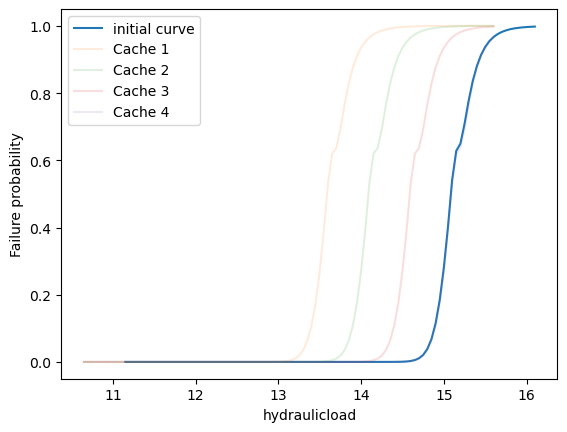

In [22]:
fig, ax = plt.subplots()
fragility_curve.as_dataframe().set_index("hydraulicload").plot(ax=ax)
ax.set_ylabel("Failure probability")
# Plot de cached curves
for i in fragility_curve.cached_fragility_curves:
    cached_curve = fragility_curve.copy()
    cached_curve.load_effect_from_data_adapter(i)
    cached_curve.as_dataframe().set_index("hydraulicload").plot(
        ax=ax, label=f"Cache {i}", alpha=0.15
    )
ax.legend(["initial curve", "Cache 1", "Cache 2", "Cache 3", "Cache 4", "Cache 5"]);

In [23]:
fragility_curve.load_effect_from_data_adapter(1)

In [24]:
fragility_curve.as_dataframe()

,hydraulicload,failure_probability
0,10.65,0.000000e+00
1,10.75,0.000000e+00
2,10.85,3.618435e-195
3,10.95,3.250255e-134
4,11.05,8.005856e-95
...,...,...
75,15.40,1.000000e+00
76,15.45,1.000000e+00
77,15.50,1.000000e+00
78,15.55,1.000000e+00


In [25]:
data_adapter.output("resulting_fragility_curve", fragility_curve.as_dataframe())